### Loading Libraries

In [1]:
import comet_ml
import os

In [2]:
# Connecting to COMET_ML
%env COMET_API_KEY=hsqjOnFKm2WYWh03tw4illwtJ
comet_ml.login(project_name="Comet_YOLO11")

# Set environment variables for Comet
# The number of images to predict and log to Comet from validation dataset
os.environ["COMET_MAX_IMAGE_PREDICTIONS"] = "30"
# The nuber of batches after which to log metrics to Comet
os.environ["COMET_EVAL_BATCH_LOGGING_INTERVAL"] = "4"
# Wether to log confusion matrix after every epoch
os.environ["COMET_EVAL_LOG_CONFUSION_MATRIX"] = "true"
# Wether to Display mAP , precision, recall and F1 score for each class
os.environ["COMET_LOG_PER_CLASS_METRICS"] = "true"

env: COMET_API_KEY=hsqjOnFKm2WYWh03tw4illwtJ


In [3]:
import roboflow
import ultralytics
from ultralytics import YOLO
from roboflow import Roboflow
import cv2
from Image_Resize_Function import image_resize
import supervision as sv
from importlib import reload
import tqdm

### Getting Data from Roboflow

In [ ]:
# setting current working directory
import os

### Dont use absolute paths
os.chdir("c:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T")

from roboflow import Roboflow
rf = Roboflow(api_key="022GaTg2BBRBT6lOHMzJ")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(14)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


### Custom Training the YOLO on this Dataset

In [5]:
# loading the data
from pathlib import Path

# base directory
base_dir = Path(
    "c:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/football_players_detection_14"
)

data_yaml_path = base_dir / "data.yaml"

if not data_yaml_path.exists():
    raise FileNotFoundError(f"data.yaml file not found: {data_yaml_path}")

In [6]:
import os
os.chdir(
    "c:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T"
)
model = YOLO("yolo11l.pt")  # load a pretrained YOLOv8n model

In [7]:
import torch
torch.cuda.empty_cache()

In [ ]:
import gc

os.chdir(
    "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T"
)

# snapshot = "memory_snapshot"

# torch.cuda.memory._record_memory_history(max_entries=100000)

def trainer (model, data_yaml_path, epochs=2, imgsz=1280, seed=42, optimizer="auto", batch=6, patience=5, device=0, dropout=0.3):
    # Train the model
    results = model.train(
        data=str(data_yaml_path), 
        epochs=epochs, 
        imgsz=imgsz, 
        seed=seed, 
        optimizer=optimizer, 
        batch=batch,
        patience = patience,
        device = device,
        dropout = dropout
    )
    return results

trainer(model, data_yaml_path, 
        epochs=2, 
        imgsz=1280, 
        seed=42, 
        optimizer="auto", 
        batch=6, 
        patience=5, 
        device=0, 
        dropout=0.3)

# Regaining GPU memory
del model  # Assuming model is accessible here
gc.collect()
torch.cuda.empty_cache()

# try:

#     torch.cuda.memory._dump_snapshot(f"{snapshot}.pickle")

# except Exception as e:

#      logger.error(f"Failed to capture memory snapshot {e}")


# torch.cuda.memory._record_memory_history(enabled=None)

In [ ]:
! pip install -q gdown inference-gpu
! pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

In [ ]:
! pip install -q git+https://github.com/roboflow/sports.git
! pip install -q supervision

### Downloading Videos from Gdrive (using gdown)

In [ ]:
os.chdir(
    "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos"
)

!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

### Model Inference 01

In [4]:
# Open the video file
video_path = (
    "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/0bfacc_0.mp4"
)

model = YOLO("runs/detect/train/weights/best.pt")

cap = cv2.VideoCapture(video_path)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLO inference on the frame
        results = model.predict(
            source=frame,
            conf=0.2,
        )

        detections = sv.Detections.from_ultralytics(results[0])

        box_annotator = sv.BoxAnnotator()
        label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
        annotated_image = frame
        annotated_image = box_annotator.annotate(annotated_image, detections=detections)
        annotated_image = label_annotator.annotate(
            annotated_image, detections=detections
        )

        # resize the annotated image for display
        annotated_image = image_resize(annotated_image, w = 1100 , h= 1100)

        # Display the annotated frame
        cv2.imshow("YOLO Inference", annotated_image)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord(" "):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()





0: 736x1280 20 players, 3 referees, 92.4ms
Speed: 19.7ms preprocess, 92.4ms inference, 268.2ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 20 players, 3 referees, 13.4ms
Speed: 12.1ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 23 players, 3 referees, 17.3ms
Speed: 8.4ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 21 players, 2 referees, 12.3ms
Speed: 8.4ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 23 players, 2 referees, 11.2ms
Speed: 7.7ms preprocess, 11.2ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 22 players, 2 referees, 13.0ms
Speed: 7.3ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 22 players, 2 referees, 12.1ms
Speed: 8.2ms preprocess, 12.1ms inference, 1.5ms postprocess per image at sh

### Model Inference 02 (Ellipse Annotators)

In [5]:
# Open the video file
video_path = "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/0bfacc_0.mp4"

model = YOLO("runs/detect/train/weights/best.pt")

cap = cv2.VideoCapture(video_path)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLO inference on the frame
        results = model.predict(
            source=frame,
            conf=0.2,
        )

        detections = sv.Detections.from_ultralytics(results[0])

        ellipse_annotator = sv.EllipseAnnotator()
        annotated_frame = ellipse_annotator.annotate(
            frame, detections=detections,
        )

        label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
        annotated_image = label_annotator.annotate(
            annotated_frame, detections=detections
        )

        # resize the annotated image for display
        annotated_image = image_resize(annotated_image, w=1100, h=1100)

        # Display the annotated frame
        cv2.imshow("YOLO Inference", annotated_image)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord(" "):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


0: 736x1280 20 players, 3 referees, 41.1ms
Speed: 9.5ms preprocess, 41.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 20 players, 3 referees, 34.7ms
Speed: 14.4ms preprocess, 34.7ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 23 players, 3 referees, 11.9ms
Speed: 13.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 21 players, 2 referees, 11.4ms
Speed: 9.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 23 players, 2 referees, 11.8ms
Speed: 9.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 22 players, 2 referees, 11.9ms
Speed: 11.3ms preprocess, 11.9ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
618

0: 736x1280 22 players, 2 referees, 16.5ms
Speed: 13.3ms preprocess, 16.5ms inference, 2.9ms postprocess per image at sh

### Running on Single Video Frame (Ellipse & Triangle & NMS)

In [8]:
# Open the video file
video_path = "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/0bfacc_0.mp4"

# Load the Custom Trained YOLO Model
model = YOLO("runs/detect/train/weights/best.pt")

# Create a video frames generator
frame_generator = sv.get_video_frames_generator(video_path)
# Get the first frame from the generator
frame = next(frame_generator)

# Run YOLO inference on the frame and get the results
results = model.predict(
            source=frame,
            conf=0.2,
        )

# Getting the detections from the results
detections = sv.Detections.from_ultralytics(results[0])

# Ellipse Annotator Instance
ellipse_annotator = sv.EllipseAnnotator(
    # color=sv.ColorPalette.from_hex(
    #     [
    #         "#FF0000",  # colour is red
    #         "#00FF00",  # colour is green
    #         "#0000FF",  # colour is blue
    #     ]
    # )
)

# Triangle Annotator Instance
triangle_annotator = sv.TriangleAnnotator(
    base=20,
    height=20,
    color=sv.Color.BLUE,
)

# Creating the Label Annotator Instance
labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence in zip(detections["class_name"], detections.confidence)
]

from supervision.geometry.core import Position

label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_padding=2,
    text_position=Position.TOP_LEFT,
    text_scale=0.4,
)


# Filtering Ball Detections and Retaining just Player, Goal Keeper and Referee Detections
player_ref_goalkeeper_detections = detections[detections.class_id != 0]
player_ref_goalkeeper_detections = player_ref_goalkeeper_detections.with_nms(threshold = 0.8 , class_agnostic= True)

# Applying Ellipse Annotations using Ellipse Annotator Instance
annotated_frame = ellipse_annotator.annotate(
    frame, detections=player_ref_goalkeeper_detections
)

# Getting the Ball Detections and Padding the Boxes
ball_detections = detections[detections.class_id == 0]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px = 10)

# Applying Triangle Annotations using Triangle Annotator Instance
annotated_frame = triangle_annotator.annotate(
    annotated_frame, detections=ball_detections
)

# Applying Label Annotations using Label Annotator Instance
annotated_frame = label_annotator.annotate(
    annotated_frame, detections=player_ref_goalkeeper_detections, labels=labels
)

# resize the annotated image for display
annotated_image = image_resize(annotated_frame, w=1300, h=1300)

# Display the annotated frame
cv2.imshow("YOLO Inference", annotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


0: 736x1280 20 players, 3 referees, 48.3ms
Speed: 9.4ms preprocess, 48.3ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)
731


### Model Inference 03 (Tracker Added)

In [7]:
# Open the video file
video_path = "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/0bfacc_0.mp4"

# Load the Custom Trained YOLO Model
model = YOLO("runs/detect/train/weights/best.pt")

# Adding Tracker
tracker = sv.ByteTrack()
tracker.reset()

# Create a video frames generator
frame_generator = sv.get_video_frames_generator(video_path)
# Get the first frame from the generator
frame = next(frame_generator)

# Run YOLO inference on the frame and get the results
results = model.predict(
    source=frame,
    conf=0.2,
)

# Getting the detections from the results
detections = sv.Detections.from_ultralytics(results[0])

# Ellipse Annotator Instance
ellipse_annotator = sv.EllipseAnnotator(
    # color=sv.ColorPalette.from_hex(
    #     [
    #         "#FF0000",  # colour is red
    #         "#00FF00",  # colour is green
    #         "#0000FF",  # colour is blue
    #     ]
    # )
)

# Triangle Annotator Instance
triangle_annotator = sv.TriangleAnnotator(
    base=20,
    height=20,
    color=sv.Color.BLUE,
)

# Creating the Label Annotator Instance


from supervision.geometry.core import Position

label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_padding=2,
    text_position=Position.TOP_LEFT,
    text_scale=0.4,
)


# Filtering Ball Detections and Retaining just Player, Goal Keeper and Referee Detections
player_ref_goalkeeper_detections = detections[detections.class_id != 0]
player_ref_goalkeeper_detections = player_ref_goalkeeper_detections.with_nms(
    threshold=0.8, class_agnostic=True
)

# Applying Tracking to the Detections
player_ref_goalkeeper_detections = tracker.update_with_detections(detections=player_ref_goalkeeper_detections)
print(player_ref_goalkeeper_detections)

# Applying Ellipse Annotations using Ellipse Annotator Instance
annotated_frame = ellipse_annotator.annotate(
    frame, detections=player_ref_goalkeeper_detections
)

# Getting the Ball Detections and Padding the Boxes
ball_detections = detections[detections.class_id == 0]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

# Applying Triangle Annotations using Triangle Annotator Instance
annotated_frame = triangle_annotator.annotate(
    annotated_frame, detections=ball_detections
)

# Applying Label Annotations using Label Annotator Instance

labels = [
    # f"{class_name} {confidence:.2f}"
    # for class_name, confidence in zip(detections["class_name"], detections.confidence)
    f"#{tracker_id}"
    for tracker_id in player_ref_goalkeeper_detections.tracker_id
]

annotated_frame = label_annotator.annotate(
    annotated_frame, detections=player_ref_goalkeeper_detections, labels=labels
)

# resize the annotated image for display
annotated_image = image_resize(annotated_frame, w=1300, h=1300)

# Display the annotated frame
cv2.imshow("YOLO Inference", annotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


0: 736x1280 20 players, 3 referees, 49.1ms
Speed: 12.8ms preprocess, 49.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Detections(xyxy=array([[     1225.4,      454.28,        1256,      501.75],
       [     715.67,      365.95,       735.7,       419.5],
       [     1362.6,      455.72,      1395.6,      512.27],
       [       1085,      500.36,      1107.4,      576.12],
       [     587.52,      395.71,      611.52,      448.98],
       [     1479.1,      413.13,      1506.2,      476.29],
       [     1351.6,      369.82,      1378.7,      423.01],
       [     1142.8,      647.34,      1180.9,       727.7],
       [        587,      458.29,      607.91,       529.8],
       [     558.77,      486.43,       579.4,      550.04],
       [     649.41,      363.65,      677.54,       414.3],
       [     1451.1,      409.04,      1470.9,      466.37],
       [     294.01,      671.91,      333.29,      758.14],
       [       1532,      518.12,      1551.7,  

### Tracking on Video

In [9]:
# Open the video file
video_path = "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/2e57b9_0.mp4"

model = YOLO("runs/detect/train2/weights/best.pt")

# Adding Tracker
tracker = sv.ByteTrack(track_activation_threshold=0.25)
tracker.reset()

cap = cv2.VideoCapture(video_path)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLO inference on the frame and get the results
        results = model.predict(
            source=frame,
            conf=0.5,
        )

        # Getting the detections from the results
        detections = sv.Detections.from_ultralytics(results[0])

        # Ellipse Annotator Instance
        ellipse_annotator = sv.EllipseAnnotator(
            # color=sv.ColorPalette.from_hex(
            #     [
            #         "#FF0000",  # colour is red
            #         "#00FF00",  # colour is green
            #         "#0000FF",  # colour is blue
            #     ]
            # )
        )

        # Triangle Annotator Instance
        triangle_annotator = sv.TriangleAnnotator(
            base=20,
            height=20,
            color=sv.Color.BLUE,
        )

        # Creating the Label Annotator Instance


        from supervision.geometry.core import Position

        label_annotator = sv.LabelAnnotator(
            text_color=sv.Color.BLACK,
            text_padding=2,
            text_position=Position.TOP_LEFT,
            text_scale=0.4,
        )

        # Filtering Ball Detections and Retaining just Player, Goal Keeper and Referee Detections
        player_ref_goalkeeper_detections = detections[detections.class_id != 0]
        player_ref_goalkeeper_detections = player_ref_goalkeeper_detections.with_nms(
            threshold=0.3, class_agnostic=True
        )

        # Applying Tracking to the Detections
        player_ref_goalkeeper_detections = tracker.update_with_detections(detections=player_ref_goalkeeper_detections)
        print(player_ref_goalkeeper_detections)

        # Applying Ellipse Annotations using Ellipse Annotator Instance
        annotated_frame = ellipse_annotator.annotate(
            frame, detections=player_ref_goalkeeper_detections
        )

        # Getting the Ball Detections and Padding the Boxes
        ball_detections = detections[detections.class_id == 0]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # Applying Triangle Annotations using Triangle Annotator Instance
        annotated_frame = triangle_annotator.annotate(
            annotated_frame, detections=ball_detections
        )

        # Applying Label Annotations using Label Annotator Instance

        labels = [
            # f"{class_name} {confidence:.2f}"
            # for class_name, confidence in zip(detections["class_name"], detections.confidence)
            f"#{tracker_id}"
            for tracker_id in player_ref_goalkeeper_detections.tracker_id
        ]

        annotated_frame = label_annotator.annotate(
            annotated_frame, detections=player_ref_goalkeeper_detections, labels=labels
        )

        # resize the annotated image for display
        annotated_image = image_resize(annotated_frame, w=1300, h=1300)

        # Display the annotated frame
        cv2.imshow("YOLO Inference", annotated_image)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord(" "):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


0: 736x1280 21 players, 1 referee, 18.3ms
Speed: 7.3ms preprocess, 18.3ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Detections(xyxy=array([[     328.07,      391.05,      350.81,      440.67],
       [     1460.5,      390.35,      1483.1,      450.07],
       [     487.98,      285.22,      506.28,      327.25],
       [     1004.5,      517.43,      1028.5,      577.97],
       [       1184,      273.93,      1204.1,      315.53],
       [     630.06,      309.71,      647.28,       356.1],
       [     1217.2,      329.73,      1232.9,      376.77],
       [     836.34,      411.05,      857.84,      459.88],
       [     957.67,      299.88,      970.84,      347.92],
       [     1335.9,      498.22,      1359.8,      568.32],
       [     923.24,      283.65,      939.24,      328.82],
       [     1105.8,      312.92,      1117.4,      353.27],
       [     1353.9,      302.89,      1376.1,      351.09],
       [     693.92,      262.03,      708.66,    

In [ ]:
!nvidia-smi

### Segmenting the Players Into Teams

Frame_Iteration: 0it [00:00, ?it/s]


0: 736x1280 1 ball, 21 players, 1 referee, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Frame_Iteration: 1it [00:00,  2.24it/s]

Detections(xyxy=array([[     1412.4,      464.18,      1442.5,      512.96],
       [     1453.7,       380.6,      1470.3,      420.98],
       [     403.85,      530.72,      428.32,      582.85],
       [     991.93,      395.16,      1013.9,      439.69],
       [      238.8,      499.18,      261.89,      547.39],
       [     756.13,      358.17,      773.59,      397.77],
       [     1028.5,      414.26,      1044.9,      452.35],
       [     1379.9,      574.71,      1419.3,      634.01],
       [     835.86,      732.94,      869.51,      801.34],
       [     1325.5,      410.06,      1342.3,      453.88],
       [     780.84,      529.57,      795.23,      585.47],
       [     897.55,      317.98,      911.15,       356.8],
       [     1370.4,      467.31,      1404.2,      516.83],
       [     1521.4,       639.6,      1552.9,       717.5],
       [     1517.9,      619.42,      1552.3,      687.65],
       [     685.42,      459.01,      704.45,      505.82],
       [

Frame_Iteration: 1it [00:01,  1.29s/it]


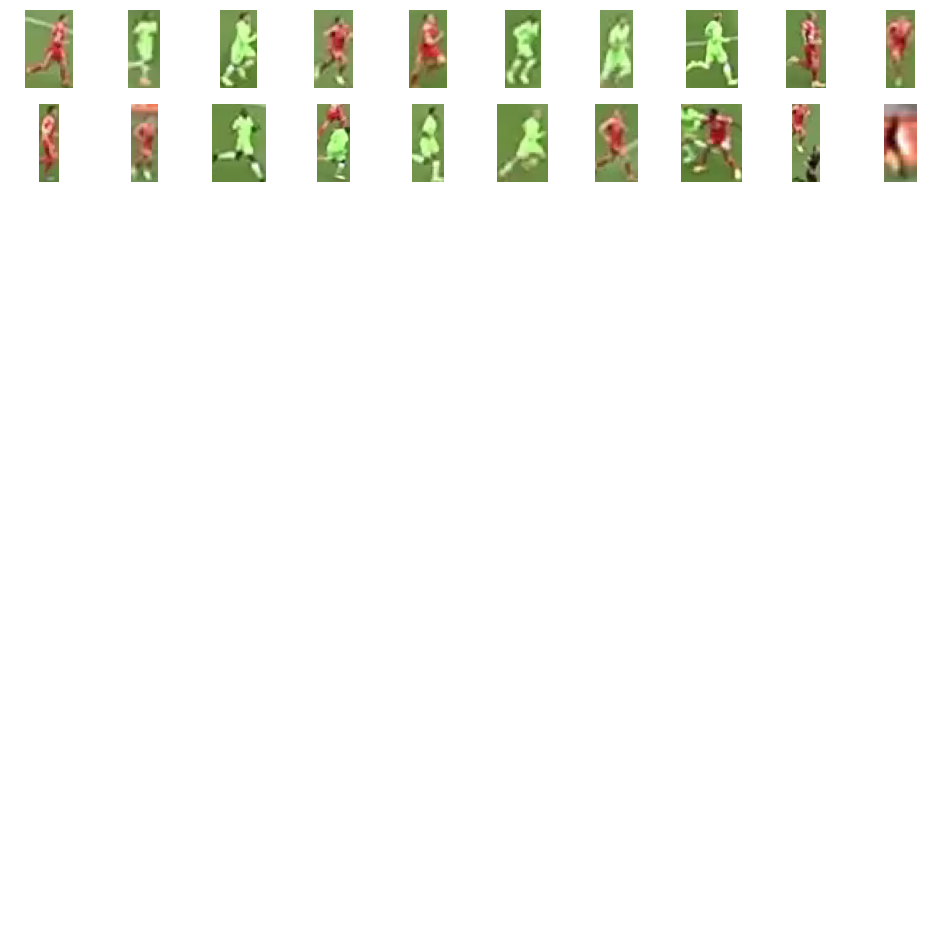

In [10]:
# Importing the tqdm loader
from tqdm import tqdm
import supervision as sv
from ultralytics import YOLO
import cv2
from Image_Resize_Function import image_resize

def get_crops(video_path , model_path , stride = 3000):

    # Open the video file
    video_path = video_path

    model = YOLO(model_path)

    # No of frames to skip
    stride = stride 

    # Create a video frames generator
    frame_generator = sv.get_video_frames_generator(video_path , stride=stride)

    crops = []

    # Loop through the video frames
    for frame in tqdm(frame_generator,desc = "Frame_Iteration"):
        # Run YOLO inference on the frame and get the results
        results = model.predict(
            source=frame,
            conf=0.5,
        )

        # Getting the detections from the results
        detections = sv.Detections.from_ultralytics(results[0])
        player_detections = detections[detections.data["class_name"] == "player"]
        print(player_detections)


        # Filtering Ball Detections and Retaining just Player, Goal Keeper and Referee Detections
        player_ref_goalkeeper_detections = detections[detections.class_id != 0]
        player_ref_goalkeeper_detections = player_ref_goalkeeper_detections.with_nms(
            threshold=0.3, class_agnostic=True
        )
        for i , xyxy in enumerate(player_ref_goalkeeper_detections.xyxy): 
            crop = sv.crop_image(frame, xyxy)
            id = player_ref_goalkeeper_detections.class_id[i]
            label = player_ref_goalkeeper_detections.data["class_name"][i]
            crops.append(crop)

            # resize the annotated image for display
            crop = image_resize(crop, w=600, h=600)
            # cv2.imshow(f"Object Type: {label}", crop)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
        # print(crops)
        # print(player_ref_goalkeeper_detections)

    return crops

video_path = "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/121364_0.mp4"
model_path = "runs/detect/train2/weights/best.pt"
stride = 2000

crops = get_crops(video_path , model_path , stride)
sv.plot_images_grid(crops[:], grid_size=(10, 10))

#### Producing Embeddings using SIGCLIP (Sigmoid with CLIP)

In [11]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = "google/siglip-base-patch16-224"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
import tqdm
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

print(type(crops[0]))  # Should be <class 'numpy.ndarray'>

#crops = [sv.cv2_to_pillow(crop) for crop in crops] # not needed as it is already in PIL Format
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in batches:
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        print(embeddings.shape)
        data.append(embeddings)

data = np.concatenate(data) # Concatenate all the batches into a single array
print(data) # (n_samples, 768) where 768 is the embedding size

<class 'numpy.ndarray'>
(20, 768)
[[     1.5176     -1.0793     -1.1661 ...      0.4442     0.34325    -0.16628]
 [    0.40472      1.2104     0.82032 ...     -1.9156    0.074856     0.74974]
 [     0.4357     0.30922      1.1934 ...      -1.503     0.41606    -0.46414]
 ...
 [      0.739    -0.90913     -1.1682 ...     0.24353    -0.22523      1.0037]
 [    0.50795     0.16207     0.39028 ...     -1.7107     0.10173     0.41029]
 [    0.36516     0.99988     0.53472 ...     -1.7335     0.80069      1.0327]]


#### Lowering Dimension of Embeddings from 768 TO 3 using UMAP (Visualization)

In [7]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3 , random_state = 42)
CLUSTERING_MODEL = KMeans(n_clusters=2 , random_state=2)

# Fit and transform the embeddings to reduce dimensionality
reduced_embeddings = REDUCER.fit_transform(data)

cluster_labels = CLUSTERING_MODEL.fit_predict(reduced_embeddings)

print(cluster_labels) # (n_samples, ) where n_samples is the number of crops

print(cluster_labels.shape) # (n_samples, ) where n_samples is the number of crops
print(type(cluster_labels)) # <class 'numpy.ndarray'>

[0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1]
(20,)
<class 'numpy.ndarray'>


#### Track Crop and Segment

In [8]:
def resolve_goalkeepers_team_id(
    players: sv.Detections, goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    print(len(players.class_id))
    print(len(players[players.class_id == 2]))
    print(len(players[players.class_id == 1]))
    print(len(goalkeepers_xy))
    team_2_centroid = players_xy[players.class_id == 2].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_2 = np.linalg.norm(goalkeeper_xy - team_2_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(2 if dist_2 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

In [ ]:
import umap
from sklearn.cluster import KMeans
import numpy as np
from more_itertools import chunked
import torch
from transformers import AutoProcessor, SiglipVisionModel

# Open the video file
video_path = "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/2e57b9_0.mp4"

model = YOLO("runs/detect/train2/weights/best.pt")

# Adding Tracker
tracker = sv.ByteTrack(track_activation_threshold=0.25)
tracker.reset()

cap = cv2.VideoCapture(video_path)

# Initialize centroids for Team A and Team B
prev_centroids = None

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLO inference on the frame and get the results
        results = model.predict(
            source=frame,
            conf=0.5,
        )

        # Getting the detections from the results
        detections = sv.Detections.from_ultralytics(results[0])

        # Ellipse Annotator Instance
        ellipse_annotator = sv.EllipseAnnotator(
            color=sv.ColorPalette.from_hex(
                [
                    "#FF0000",  # colour is red
                    "#00FF00",  # colour is green
                    "#0000FF",  # colour is blue
                ]
            )
        )

        # Triangle Annotator Instance
        triangle_annotator = sv.TriangleAnnotator(
            base=20,
            height=20,
            color=sv.Color.BLUE,
        )

        # Creating the Label Annotator Instance

        from supervision.geometry.core import Position

        label_annotator = sv.LabelAnnotator(
            text_color=sv.Color.BLACK,
            text_padding=2,
            text_position=Position.TOP_LEFT,
            text_scale=0.4,
        )

        # Filtering Ball Detections and Retaining just Player, Goal Keeper and Referee Detections
        player_ref_goalkeeper_detections = detections[detections.class_id != 0]
        player_ref_goalkeeper_detections = player_ref_goalkeeper_detections.with_nms(
            threshold=0.3, class_agnostic=True
        )

        # Applying Tracking to the Detections
        player_ref_goalkeeper_detections = tracker.update_with_detections(
            detections=player_ref_goalkeeper_detections
        )

        # getting just player detections
        player_detections = player_ref_goalkeeper_detections[
            player_ref_goalkeeper_detections.data["class_name"] == "player"
        ]

        # Getting the Crops
        crops = []
        for i, xyxy in enumerate(player_detections.xyxy):
            crop = sv.crop_image(frame, xyxy)
            id = player_ref_goalkeeper_detections.class_id[i]
            label = player_ref_goalkeeper_detections.data["class_name"][i]
            crops.append(crop)
            # resize the annotated image for display
            crop = image_resize(crop, w=600, h=600)

        # Getting the Embeddings
        BATCH_SIZE = 32
        batches = chunked(crops, BATCH_SIZE)
        data = []
        with torch.no_grad():
            for batch in batches:
                inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
                outputs = EMBEDDINGS_MODEL(**inputs)
                embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
                data.append(embeddings)
            data = np.concatenate(data) # Concatenate all the batches into a single array

        # Reducing the Dimension using UMAP
        reduced_embeddings = REDUCER.fit_transform(data)

        # clustering the embeddings using K-Means
        cluster_labels = CLUSTERING_MODEL.fit_predict(reduced_embeddings)
        centroids = (
            CLUSTERING_MODEL.cluster_centers_
        )  # e.g., [[195, 55, 45], [55, 45, 195]]

        if prev_centroids is None:
            # First frame: arbitrary or reference-based assignment
            prev_centroids = centroids.copy()
            team_labels = cluster_labels  # 0 for Team A, 1 for Team B 
            print(f"Frame 1 - Labels: {team_labels}")
        else:
            # Compute distances to previous centroids
            dist_to_team_a = np.linalg.norm(centroids - prev_centroids, axis=1)
            print("Dist to team A" , dist_to_team_a)
            # Assign Team A to the closest centroid
            team_a_idx = np.argmin(dist_to_team_a)
            print(team_a_idx)
            print(f"Team A Index: {team_a_idx}")
            team_b_idx = 1 - team_a_idx  # The other cluster
            # Map new labels: team_a_idx becomes 0 (Team A), team_b_idx becomes 1 (Team B)
            team_labels = np.where(cluster_labels == team_a_idx, 0, 1)
            # Update centroids in consistent order
            prev_centroids = np.array([centroids[team_a_idx], centroids[team_b_idx]])
            print(f"Next Frame - Labels: {team_labels}")

        cluster_labels = team_labels
        cluster_labels = np.where(cluster_labels == 0 , 2 , cluster_labels).astype(int)# removing the 0 labels

        # getting just the goal keeper detections
        goal_keeper_detections = player_ref_goalkeeper_detections[
            player_ref_goalkeeper_detections.data["class_name"] == "goalkeeper"
        ]

        # replacing player IDs with Team IDs (cluster labels)
        player_detections.class_id = cluster_labels 

        # now we will assign IDs (1 or 2) to the goal keepers
        gk_team_id = resolve_goalkeepers_team_id(player_detections, goal_keeper_detections)

        # replacing gk IDs with calculated gk IDs
        goal_keeper_detections.class_id = gk_team_id.astype(int)

        referees_detections = player_ref_goalkeeper_detections[player_ref_goalkeeper_detections.data["class_name"] == "referee"]

        all_detections = sv.Detections.merge(
            [player_detections, goal_keeper_detections, referees_detections]
        )

        # Applying Ellipse Annotations using Ellipse Annotator Instance
        annotated_frame = ellipse_annotator.annotate(
            frame, detections=all_detections
        )

        # Getting the Ball Detections and Padding the Boxes
        ball_detections = detections[detections.class_id == 0]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # Applying Triangle Annotations using Triangle Annotator Instance
        annotated_frame = triangle_annotator.annotate(
            annotated_frame, detections=ball_detections
        )

        # Applying Label Annotations using Label Annotator Instance

        labels = [
            # f"{class_name} {confidence:.2f}"
            # for class_name, confidence in zip(detections["class_name"], detections.confidence)
            f"#{tracker_id}"
            for tracker_id in all_detections.tracker_id
        ]

        annotated_frame = label_annotator.annotate(
            annotated_frame, detections=all_detections, labels=labels
        )

        # resize the annotated image for display
        annotated_image = image_resize(annotated_frame, w=1300, h=1300)

        # Display the annotated frame
        cv2.imshow("YOLO Inference", annotated_image)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord(" "):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()

### Keypoint Detection

In [13]:
# setting current working directory
import os

os.chdir(
    "c:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T"
)

from roboflow import Roboflow
rf = Roboflow(api_key="022GaTg2BBRBT6lOHMzJ")
project = rf.workspace("roboflow-jvuqo").project("football-field-detection-f07vi")
version = project.version(15)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


#### Because we dont have enough resources so we will use pretrained model from RoboFlow

In [9]:
from inference import get_model

# load a pre-trained yolov8n model
pitch_keypoint_model = get_model(
    model_id="football-field-detection-f07vi/15", api_key="022GaTg2BBRBT6lOHMzJ"
)

[05/02/25 20:22:46] WARNING  Your inference package version 0.45.0 is out of date! Please upgrade to ]8;id=106798;file://c:\Users\huzin\AppData\Local\Programs\Python\Python310\lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=452433;file://c:\Users\huzin\AppData\Local\Programs\Python\Python310\lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.48.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

ModelDependencyMissing: Your `inference` configuration does not support PaliGemma model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Florence2 model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[clip]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does

#### Running Inference on Pitch Picture and Getting Keypoint Locations on Pitch

KeyPoints(xy=array([[[        263,         265],
        [        125,         324],
        [         97,         386],
        [         96,         454],
        [        471,         333],
        [        341,         406],
        [        141,         527],
        [       1337,         290],
        [       1344,         420],
        [       1353,         596],
        [       1354,        1080],
        [       1048,         487],
        [       1645,         505]]], dtype=float32), class_id=None, confidence=None, data={})


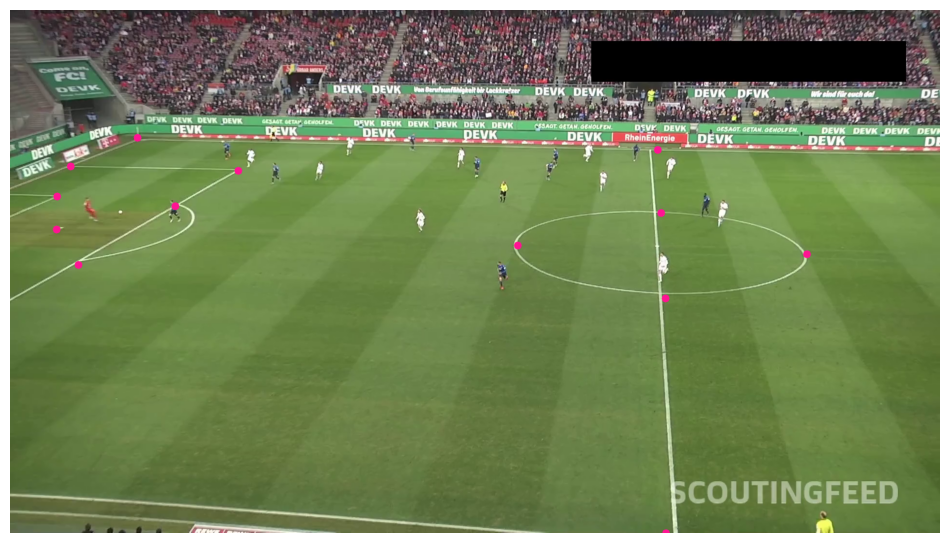

In [10]:
import supervision as sv
import numpy as np


video_path = "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/2e57b9_0.mp4"


vertex_annotator = sv.VertexAnnotator(color=sv.Color.from_hex("#FF1493"), radius=8)


frame_generator = sv.get_video_frames_generator(video_path)

frame = next(frame_generator)


result = pitch_keypoint_model.infer(frame, confidence=0.3)[0]

key_points = sv.KeyPoints.from_inference(result)



filter = key_points.confidence[0]>0.5

points = key_points.xy[0][filter]

# producing keypoints object
frame_reference_key_points = sv.KeyPoints(xy=points[np.newaxis, ...])

print(frame_reference_key_points)

annotated_frame = frame.copy()

annotated_frame = vertex_annotator.annotate(

    scene=annotated_frame, key_points=frame_reference_key_points
)


sv.plot_image(annotated_frame)

### Drawing the Top View Field with Pre-calculated Points

In [11]:
import os
# set current working directory
os.chdir = (
    "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/sports"
)

(7060, 12060, 3)


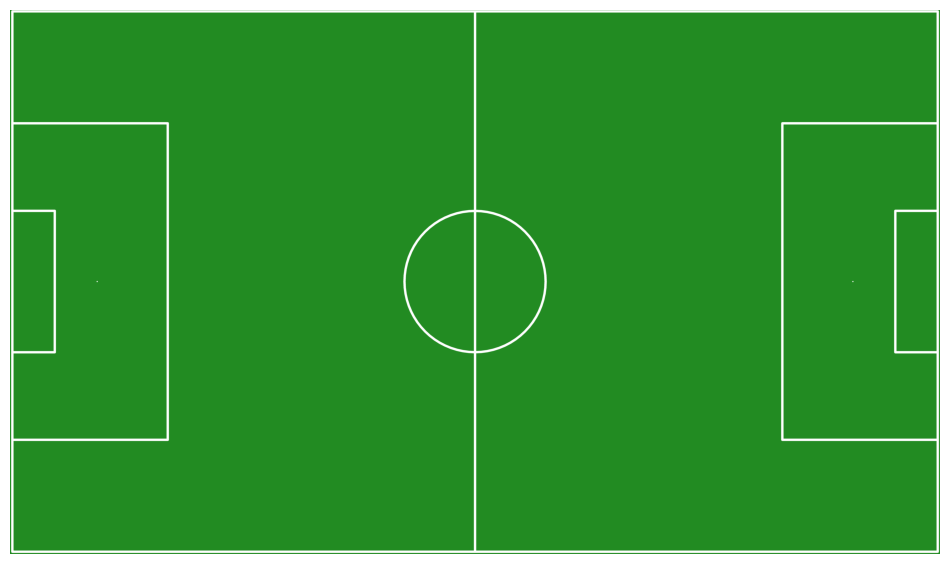

In [31]:
from sports.sports.annotators import soccer
from sports.sports.configs.soccer import SoccerPitchConfiguration

reload(soccer)

CONFIG = SoccerPitchConfiguration()

top_view_annotated_frame = soccer.draw_pitch(CONFIG , scale=1)

print(top_view_annotated_frame.shape)

sv.plot_image(top_view_annotated_frame)

#### Transforming Points Using Homography

In [13]:
import cv2

class ViewTransformer:
    def __init__(self, source:np.ndarray, target:np.ndarray):
        source = source.astype(np.float32) # not accessible , just used to caliculate homography
        target = target.astype(np.float32) # not accessible , just used to caliculate homography
        self.m , _ = cv2.findHomography(source, target)

    def transform_points(self, points:np.ndarray) -> np.ndarray:
        points = points.reshape(-1,1,2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1,2).astype(np.float32)
    
    

KeyPoints(xy=array([[[     252.12,      279.05],
        [     120.86,      332.57],
        [    -6.4975,      384.49],
        [    -280.78,      496.33],
        [    -515.35,      591.97],
        [     -937.9,      764.27],
        [     90.736,       387.3],
        [     -170.1,      502.61],
        [      81.33,      443.91],
        [     469.22,      338.48],
        [     371.16,      395.38],
        [     154.62,      521.03],
        [    -36.607,         632],
        [     1335.4,      284.91],
        [     1338.1,      423.32],
        [     1341.3,      588.25],
        [       1351,      1086.4],
        [     2564.9,      374.05],
        [     2775.4,      464.69],
        [     3323.9,      700.85],
        [     3935.1,      964.06],
        [     3530.5,      585.51],
        [     3496.9,      485.48],
        [       4434,      763.84],
        [     3046.3,      294.18],
        [     3403.2,      388.28],
        [     3805.7,      494.39],
        [     4

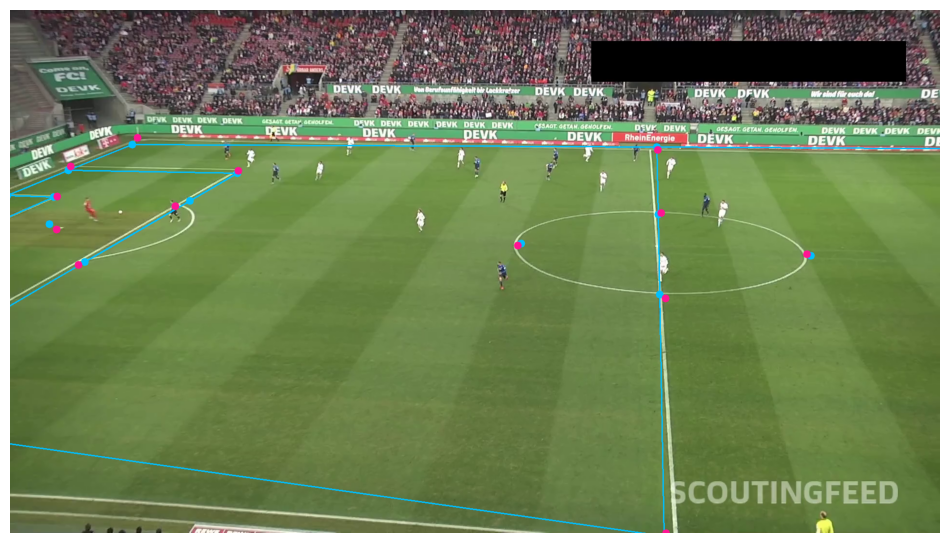

In [14]:
import supervision as sv
import numpy as np

edge_annotator = sv.EdgeAnnotator(color=sv.Color.from_hex("#00BFFF"), thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(color=sv.Color.from_hex("#FF1493"), radius=8)
vertex_annotator_2 = sv.VertexAnnotator(color=sv.Color.from_hex("#00BFFF"), radius=8)

video_path = "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/2e57b9_0.mp4"

vertex_annotator = sv.VertexAnnotator(color=sv.Color.from_hex("#FF1493"), radius=8)

frame_generator = sv.get_video_frames_generator(video_path)
frame = next(frame_generator)
result = pitch_keypoint_model.infer(frame, confidence=0.3)[0]

key_points = sv.KeyPoints.from_inference(result)
filter = key_points.confidence[0] > 0.5
points = key_points.xy[0][filter]

# producing keypoints object
frame_reference_key_points = sv.KeyPoints(xy=points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]  # This filter filters the vertices as well

model_transformer = ViewTransformer(
    source=pitch_reference_points.reshape(-1,2) , 
    target=frame_reference_key_points.xy[0].reshape(-1,2)
) 

pitch_all_points = np.array(CONFIG.vertices) # all pitch points

frame_all_points = model_transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

print(frame_all_key_points)


annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame, key_points=frame_all_key_points
)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame, key_points=frame_all_key_points
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame, key_points=frame_reference_key_points
)


sv.plot_image(annotated_frame)

#### Transfroming from Field View to Top Down Pitch View

##### Function to Detect Keypoints, Homography and Initialise Transformer

In [15]:
def set_model_transformer(frame):   
    result = pitch_keypoint_model.infer(frame, confidence=0.3)[0]

    key_points = sv.KeyPoints.from_inference(result)
    filter = key_points.confidence[0] > 0.5
    points = key_points.xy[0][filter]

    # producing keypoints object
    frame_reference_key_points = sv.KeyPoints(xy=points[np.newaxis, ...])

    pitch_reference_points = np.array(CONFIG.vertices)[
        filter
    ]  # This filter filters the vertices as well

    model_transformer = ViewTransformer(
        source=frame_reference_key_points.xy[0].reshape(-1, 2),
        target=pitch_reference_points.reshape(-1, 2)
    )

    return (model_transformer , points)

### Generating a Team Classifier

### We fit the KMeans classifier on a large num of crops to keep the classification space the same in each prediction attempt

In [27]:
import os
os.chdir = (
    "c:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T"
)
model = YOLO("yolo11l.pt")  # load a pretrained YOLOv8n model

In [28]:
from sports.sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/2e57b9_0.mp4"

PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in frame_generator:
    result = model.predict(source=frame,conf=0.3,device = "cuda:0")[0]
    detections = sv.Detections.from_ultralytics(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)


0: 384x640 20 persons, 25.6ms
Speed: 1.7ms preprocess, 25.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 26.1ms
Speed: 2.6ms preprocess, 26.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 27.8ms
Speed: 3.3ms preprocess, 27.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 24.4ms
Speed: 2.0ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 27.0ms
Speed: 2.6ms preprocess, 27.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 25.5ms
Speed: 3.7ms preprocess, 25.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 24.5ms
Speed: 2.5ms preprocess, 24.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 25.0ms
Speed: 2.5ms preprocess, 25.0ms inference, 1.2ms postprocess per image at

Embedding extraction: 16it [00:07,  2.13it/s]


In [35]:
import umap
from sklearn.cluster import KMeans
import numpy as np
from more_itertools import chunked
import torch
from transformers import AutoProcessor, SiglipVisionModel

# Open the video file
video_path = "C:/Users/huzin/Downloads/Huzaifah_Folder/Computer_Vision_Course/Football_D_S_T/Videos/2e57b9_0.mp4"

model = YOLO("runs/detect/train2/weights/best.pt")

# Adding Tracker
tracker = sv.ByteTrack(track_activation_threshold=0.25)
tracker.reset()

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex("#FF1493"), radius=200
)

vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.ColorPalette.from_matplotlib('viridis', 2),
    radius=200,
)

vertex_annotator_3 = sv.VertexAnnotator(
    color=sv.Color.from_hex("#FF1800"),
    radius=200,
)

cap = cv2.VideoCapture(video_path)

# Initialize centroids for Team A and Team B
prev_centroids = None

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLO inference on the frame and get the results
        results = model.predict(
            source=frame,
            conf=0.5,
            device = "cuda:0"
        )

        # Getting the detections from the results
        detections = sv.Detections.from_ultralytics(results[0])

        # Ellipse Annotator Instance
        ellipse_annotator = sv.EllipseAnnotator(
            color=sv.ColorPalette.from_hex(
                [
                    "#FF0000",  # colour is red
                    "#00FF00",  # colour is green
                    "#0000FF",  # colour is blue
                ]
            )
        )

        # Triangle Annotator Instance
        triangle_annotator = sv.TriangleAnnotator(
            base=20,
            height=20,
            color=sv.Color.BLUE,
        )

        # Creating the Label Annotator Instance

        from supervision.geometry.core import Position

        label_annotator = sv.LabelAnnotator(
            text_color=sv.Color.BLACK,
            text_padding=2,
            text_position=Position.TOP_LEFT,
            text_scale=0.4,
        )

        # Filtering Ball Detections and Retaining just Player, Goal Keeper and Referee Detections
        player_ref_goalkeeper_detections = detections[detections.class_id != 0]
        player_ref_goalkeeper_detections = player_ref_goalkeeper_detections.with_nms(
            threshold=0.3, class_agnostic=True
        )

        # Applying Tracking to the Detections
        player_ref_goalkeeper_detections = tracker.update_with_detections(
            detections=player_ref_goalkeeper_detections
        )

        # getting just player detections
        player_detections = player_ref_goalkeeper_detections[
            player_ref_goalkeeper_detections.data["class_name"] == "player"
        ]

        # getting just ball detections
        ball_detections = detections[detections.data["class_name"] == "ball"]

        # Getting the Crops
        crops = []
        for i, xyxy in enumerate(player_detections.xyxy):
            crop = sv.crop_image(frame, xyxy)
            id = player_ref_goalkeeper_detections.class_id[i]
            label = player_ref_goalkeeper_detections.data["class_name"][i]
            crops.append(crop)
            # resize the annotated image for display
            crop = image_resize(crop, w=600, h=600)

        # # Getting the Embeddings
        # BATCH_SIZE = 32
        # batches = chunked(crops, BATCH_SIZE)
        # data = []
        # with torch.no_grad():
        #     for batch in batches:
        #         inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(
        #             DEVICE
        #         )
        #         outputs = EMBEDDINGS_MODEL(**inputs)
        #         embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        #         data.append(embeddings)
        #     data = np.concatenate(
        #         data
        #     )  # Concatenate all the batches into a single array

        # # Reducing the Dimension using UMAP
        # reduced_embeddings = REDUCER.fit_transform(data)

        # # clustering the embeddings using K-Means
        # cluster_labels = CLUSTERING_MODEL.fit_predict(reduced_embeddings)
        # centroids = (
        #     CLUSTERING_MODEL.cluster_centers_
        # )  # e.g., [[195, 55, 45], [55, 45, 195]]

        # if prev_centroids is None:
        #     # First frame: arbitrary or reference-based assignment
        #     prev_centroids = centroids.copy()
        #     cent = centroids.copy()
        #     print("Pev Cent" , prev_centroids)
        #     team_labels = cluster_labels  # 0 for Team A, 1 for Team B
        #     print(f"Frame 1 - Labels: {team_labels}")
        # else:
        #     # Compute distances to previous centroids
        #     print("Current Centroids" , centroids)
        #     #dist_to_team_a = np.linalg.norm(centroids - prev_centroids[0], axis=1)
        #     dist0 = np.linalg.norm(centroids - cent[0], axis=1)
        #     dist1 = np.linalg.norm(centroids - cent[1], axis=1)
        #     concat= np.vstack((dist0 , dist1))
        #     print(concat)
        #     idx = np.argmin(concat, axis = 0) # checking smallest across columns
        #     if idx[0] == idx[1]:
        #         print("Same Hero")
        #         if concat[idx[0],0] < concat[idx[1],1]:
        #             print("Smallest in 0th Column")
        #             smallest = 0 # smallest is in first column at idx[0] row num
        #             if idx[0] == 0:
        #                 print(f"Centroid 0 is in Team A")
        #                 team_a_idx = smallest
        #                 team_b_idx = 1 - smallest
        #             else:
        #                 print(f"Centroid 0 is in Team B")
        #                 team_b_idx = smallest
        #                 team_a_idx = 1 - smallest
        #         else:
        #             print("Smallest in 1st Column")
        #             smallest = 1 # smallest is in second column at idx[1] row num
        #             if idx[0] == 0:
        #                 print(f"Centroid 1 is in Team A")
        #                 team_a_idx = smallest
        #                 team_b_idx = 1 - smallest
        #             else:
        #                 print(f"Centroid 1 is in Team B")
        #                 team_b_idx = smallest
        #                 team_a_idx = 1 - smallest
        #     else:
        #         print("Different Hero")
        #         print(f"Centroid {idx[0]} is in Team A")
        #         team_a_idx = idx[0]
        #         print(f"Centroid {1 - idx[0]} is in Team A")
        #         team_b_idx = 1 - team_a_idx
        #     # # Assign Team A to the closest centroid
        #     # team_a_idx = np.argmin(dist_to_team_a)
        #     # #print(f"Team A Index: {team_a_idx}")
        #     # team_b_idx = 1 - team_a_idx  # The other cluster
        #     # Map new labels: team_a_idx becomes 0 (Team A), team_b_idx becomes 1 (Team B)
        #     team_labels = np.where(cluster_labels == team_a_idx, 0, 1)
        #     # Update centroids in consistent order
        #     prev_centroids = np.array([centroids[team_a_idx], centroids[team_b_idx]])
        #     cent = np.array([centroids[team_a_idx], centroids[team_b_idx]])
        #     #print(f"Next Frame - Labels: {team_labels}")

        cluster_labels = team_classifier.predict(crops)  # 0 for Team A, 1 for Team B
        cluster_labels = np.where(cluster_labels == 0, 2, cluster_labels).astype(
            int
        )  # removing the 0 labels

        # getting just the goal keeper detections
        goal_keeper_detections = player_ref_goalkeeper_detections[
            player_ref_goalkeeper_detections.data["class_name"] == "goalkeeper"
        ]

        # replacing player IDs with Team IDs (cluster labels)
        player_detections.class_id = cluster_labels

        # now we will assign IDs (1 or 2) to the goal keepers
        gk_team_id = resolve_goalkeepers_team_id(
            player_detections, goal_keeper_detections
        )

        # replacing gk IDs with calculated gk IDs
        goal_keeper_detections.class_id = gk_team_id.astype(int)

        referees_detections = player_ref_goalkeeper_detections[
            player_ref_goalkeeper_detections.data["class_name"] == "referee"
        ]

        all_detections = sv.Detections.merge(
            [player_detections, goal_keeper_detections, referees_detections]
        )

        # Transforming the points to the frame using the model transformer
        custom_transformer , real_pitch_points = set_model_transformer(frame) # transformer is initialised
        # getting player points
        player_points = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        # getting goal keeper points
        goal_keeper_points = goal_keeper_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        # getting referee points
        referee_points = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        # getting ball points
        ball_points = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

        # Annotating the points on the frame
        # top_annotated_frame = top_view_annotated_frame.copy()

        top_annotated_frame = soccer.draw_pitch(CONFIG , scale = 1)

        # applying transformation to the points
        if player_points.shape[0] >= 1:
            trans_player_points = custom_transformer.transform_points(points=player_points)
            player_key_points = sv.KeyPoints(xy=trans_player_points[np.newaxis, ...])
            player_key_points.class_id = player_detections.class_id

            print("Num of Keypoints" , len(player_key_points.xy))

            for i in range(len(player_key_points.xy[0])):
                if player_key_points.class_id[i] == 1:
                    cv2.circle(top_annotated_frame, tuple(player_key_points.xy[0,i,:].astype('int32')), 200, (255,255,0), -1)
                else:
                    cv2.circle(top_annotated_frame, tuple(player_key_points.xy[0,i,:].astype('int32')), 200, (255,0,0), -1)
    
        if goal_keeper_points.shape[0] >= 1:
            trans_goal_keeper_points = model_transformer.transform_points(points=goal_keeper_points)
            goal_keeper_key_points = sv.KeyPoints(xy=trans_goal_keeper_points[np.newaxis, ...])
            # top_annotated_frame = vertex_annotator.annotate(
            #     scene=top_annotated_frame, key_points=goal_keeper_key_points
            # )
        if referee_points.shape[0] >= 1:
            trans_referee_points = model_transformer.transform_points(points=referee_points)
            referee_key_points = sv.KeyPoints(xy=trans_referee_points[np.newaxis, ...])
            referee_key_points.class_id = referees_detections.class_id
            top_annotated_frame = vertex_annotator_3.annotate(
                scene=top_annotated_frame, key_points=referee_key_points
            )
        if ball_points.shape[0] >= 1:
            trans_ball_points = custom_transformer.transform_points(points=ball_points)
            ball_key_points = sv.KeyPoints(xy=trans_ball_points[np.newaxis, ...])
            top_annotated_frame = vertex_annotator.annotate(
                scene=top_annotated_frame, key_points=ball_key_points
            )

        # Applying Ellipse Annotations using Ellipse Annotator Instance
        annotated_frame = ellipse_annotator.annotate(frame, detections=all_detections)

        # Getting the Ball Detections and Padding the Boxes
        ball_detections = detections[detections.class_id == 0]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # Applying Triangle Annotations using Triangle Annotator Instance
        annotated_frame = triangle_annotator.annotate(
            annotated_frame, detections=ball_detections
        )

        # Applying Label Annotations using Label Annotator Instance

        labels = [
            # f"{class_name} {confidence:.2f}"
            # for class_name, confidence in zip(detections["class_name"], detections.confidence)
            f"#{tracker_id}"
            for tracker_id in all_detections.tracker_id
        ]

        annotated_frame = label_annotator.annotate(
            annotated_frame, detections=all_detections, labels=labels
        )

        # resize the annotated image for display
        annotated_image = image_resize(annotated_frame, w=900, h=900)
        top_annotated_frame = image_resize(top_annotated_frame, w=900, h=900)

        # Display the annotated frame
        cv2.imshow("YOLO Inference", annotated_image)
        cv2.imshow("Top View", top_annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord(" "):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


0: 736x1280 21 players, 1 referee, 12.8ms
Speed: 5.6ms preprocess, 12.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
276
230
257
236
285
221
204
269
162
205
213
165
275
225
229
200
162
190
225
364
207


Embedding extraction: 1it [00:00,  3.07it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 1 referee, 12.9ms
Speed: 9.6ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
276
219
257
245
285
221
204
269
162
205
213
165
275
225
229
200
162
190
225
364
207


Embedding extraction: 1it [00:00,  2.89it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 1 referee, 23.6ms
Speed: 6.9ms preprocess, 23.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
334
230
265
200
287
247
212
178
166
269
209
173
204
285
195
219
181
317
162
207
150


Embedding extraction: 1it [00:00,  2.20it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 1 referee, 13.0ms
Speed: 7.1ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
266
233
192
218
231
182
352
215
262
169
212
319
271
312
270
190
200
204
180
223


Embedding extraction: 1it [00:00,  3.02it/s]


20
10
10
0
Num of Keypoints 1
506
526

0: 736x1280 20 players, 1 referee, 12.0ms
Speed: 6.6ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
272
242
231
271
237
242
270
169
305
165
255
181
209
312
181
263
223
185
352


Embedding extraction: 1it [00:00,  3.36it/s]


19
9
10
0
Num of Keypoints 1
506
526

0: 736x1280 20 players, 1 referee, 11.1ms
Speed: 6.8ms preprocess, 11.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
316
175
200
246
260
200
247
214
160
240
293
288
241
215
237
282
257
415
225


Embedding extraction: 1it [00:00,  3.44it/s]


19
9
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 1 referee, 13.2ms
Speed: 6.5ms preprocess, 13.2ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
332
253
263
250
204
186
270
219
285
153
266
231
245
244
320
251
216
209
365
190
252


Embedding extraction: 1it [00:00,  3.22it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 22 players, 11.6ms
Speed: 6.4ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
259
257
314
182
189
195
251
281
271
285
248
208
265
368
214
230
195
219
183
257
228


Embedding extraction: 1it [00:00,  3.24it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 1 referee, 12.9ms
Speed: 7.1ms preprocess, 12.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
263
247
245
210
195
271
229
285
265
257
195
190
247
265
304
253
325
190
187
204
244


Embedding extraction: 1it [00:00,  3.25it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 1 ball, 22 players, 13.5ms
Speed: 6.9ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
217
257
242
223
281
257
210
300
242
182
248
267
245
189
191
282
185
250
186
185
242


Embedding extraction: 1it [00:00,  3.26it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 11.1ms
Speed: 6.2ms preprocess, 11.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
225
197
208
260
200
218
235
237
234
216
165
242
266
195
214
324
177
273
210
195
200


Embedding extraction: 1it [00:00,  3.23it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 2 referees, 11.1ms
Speed: 6.8ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
247
212
235
218
200
242
253
190
247
223
190
203
262
288
246
216
305
189
191
200
234


Embedding extraction: 1it [00:00,  3.24it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 20 players, 1 referee, 10.4ms
Speed: 6.8ms preprocess, 10.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
196
230
285
253
215
186
186
190
255
181
225
286
214
231
259
183
249
200
200
226


Embedding extraction: 1it [00:00,  3.43it/s]


20
10
10
0
Num of Keypoints 1
506
526

0: 736x1280 20 players, 3 referees, 10.7ms
Speed: 6.5ms preprocess, 10.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
207
222
203
219
195
253
188
221
278
218
229
215
194
259
223
253
231
204
230
190


Embedding extraction: 1it [00:00,  3.39it/s]


20
10
10
0
Num of Keypoints 1
506
526

0: 736x1280 1 ball, 22 players, 1 referee, 11.6ms
Speed: 5.9ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
249
330
248
223
266
220
200
200
213
242
209
253
187
219
227
240
139
181
185
204
154


Embedding extraction: 1it [00:00,  3.19it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 1 referee, 11.1ms
Speed: 6.1ms preprocess, 11.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
195
242
210
234
204
257
204
242
214
240
184
265
189
209
191
266
169
175
193
217
234


Embedding extraction: 1it [00:00,  3.19it/s]


21
12
9
0
Num of Keypoints 1
506
526

0: 736x1280 1 ball, 21 players, 1 referee, 11.0ms
Speed: 6.8ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
247
184
190
169
225
225
215
195
290
257
263
234
229
257
240
228
225
330
169
189
190


Embedding extraction: 1it [00:00,  3.24it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 1 ball, 21 players, 10.5ms
Speed: 5.8ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
244
293
265
195
271
230
226
160
242
195
205
223
290
184
234
218
180
229
215
210
169


Embedding extraction: 1it [00:00,  3.22it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 1 ball, 21 players, 1 referee, 11.9ms
Speed: 6.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
242
200
293
227
200
237
175
209
186
288
242
208
200
228
271
329
200
240
195
195
165


Embedding extraction: 1it [00:00,  3.23it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 1 referee, 11.1ms
Speed: 6.2ms preprocess, 11.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
238
185
196
265
251
200
270
238
180
195
216
263
309
223
231
312
247
275
255
215
165


Embedding extraction: 1it [00:00,  3.21it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 3 referees, 10.8ms
Speed: 7.4ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
171
205
294
234
196
204
231
217
263
226
337
270
276
247
251
209
153
218
225
318
200


Embedding extraction: 1it [00:00,  3.21it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 2 referees, 11.4ms
Speed: 7.0ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
242
167
275
195
257
237
207
294
195
238
208
337
226
251
173
253
210
234
218
209
270


Embedding extraction: 1it [00:00,  3.21it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 2 referees, 11.4ms
Speed: 6.7ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
150
219
270
212
300
210
242
173
237
240
228
236
222
208
225
270
214
217
263
248
242


Embedding extraction: 1it [00:00,  3.22it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 2 referees, 11.2ms
Speed: 5.5ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
266
171
231
229
235
248
200
157
195
215
280
231
243
265
208
211
245
234
228
268
228


Embedding extraction: 1it [00:00,  3.19it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 2 referees, 11.6ms
Speed: 5.8ms preprocess, 11.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
238
253
314
217
254
190
200
200
222
265
234
251
235
180
214
312
221
157
225
200
209


Embedding extraction: 1it [00:00,  3.18it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 2 referees, 11.0ms
Speed: 6.1ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
234
243
230
237
242
259
212
225
190
234
205
214
213
200
225
175
229
293
214
182
189


Embedding extraction: 1it [00:00,  3.20it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 22 players, 2 referees, 11.1ms
Speed: 5.8ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
196
220
253
259
234
195
212
220
211
185
215
242
220
200
259
167
223
195
208
242
200
210


Embedding extraction: 1it [00:00,  3.07it/s]


22
12
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 2 referees, 10.8ms
Speed: 5.8ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
192
240
245
244
195
212
203
193
244
200
232
171
250
190
208
223
223
175
208
184
234


Embedding extraction: 1it [00:00,  3.22it/s]


21
11
10
0
Num of Keypoints 1
506
526

0: 736x1280 21 players, 3 referees, 12.0ms
Speed: 5.8ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
228
190
251
271
208
293
192
210
204
242
196
237
211
219
219
195
205
188
171
205
150


Embedding extraction: 1it [00:00,  3.13it/s]


21
11
10
0
Num of Keypoints 1
506
526
